In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import folium
from folium import Choropleth, Circle, Marker, PolyLine
import squarify
import ast
import pickle
import warnings
import math

import geopy
from geopy.distance import geodesic

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from mpl_toolkits.mplot3d import Axes3D 
from datetime import datetime
from haversine import haversine

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler

In [50]:
def cal_rad(A,B):
    rad = math.atan2(A[1]-B[1], A[0]-B[0])
    return rad

def count_color(count):
    if count >=4:
        color = '#c18cd1'
    elif count ==3:
        color = '#bc65d6'
    elif count ==2:
        color = '#b940de'
    elif count ==1:
        color = '#b223de'
    else:
        color = '#9000c9'
    return color

In [51]:
def geo_cluster_color(id):
    if id == 0:
        color = '#ef476f' # 빨강
        opacity = 1
    elif id == 1:
        color = '#06d6a0' # 초록
        opacity = 0.1
    elif id == 2:
        color = '#ffd166' # 노랑
        opacity = 0.1
    elif id == 3:
        color = '#118ab2' # 파랑
        opacity = 0.1
    else:
        color = '#000000'
        opacity = 0.1
    return color, opacity

In [52]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [53]:
def cal_dist(x1, y1, x2, y2, a, b):
    area = abs((x1-a) * (y2-b) - (y1-b) * (x2 - a))
    AB = ((x1-x2)**2 + (y1-y2)**2) **0.5
    distance = area/AB
    return distance

In [54]:
#고속도로 구간별 좌표 load

traffic_df = pd.read_csv('도로종류별 교통량(좌표,휴게소,사고건수,화물차휴게소)추가_최종본.csv')
traffic_df.shape

(638, 19)

In [55]:
#휴게소 데이터 load
rest_df = pd.read_csv('고속도로 휴게소 데이터.csv')
rest_df.head()

,No,brand,convenience,direction,maintenanceYn,routeCode,routeName,serviceAreaCode,serviceAreaCode2,serviceAreaName,svarAddr,telNo,truckSaYn,경도,위도,상태
0,1,탐앤탐스 외 5,수유실|수면실||||,부산,X,10,경부선,A00001,1,서울만남(부산)휴게소,서울 서초구 원지동 10-16,02-578-3372,X,127.042145,37.460075,정좌표
1,2,탐앤탐스 외 3,NaN,부산,X,10,경부선,A00003,5,기흥(부산)휴게소,경기 용인시 기흥구 공세로 173 기흥휴게소,031-286-5001,X,127.104246,37.235329,정좌표
2,3,드롭탑 외 5,수유실|샤워실|세탁실|수면실||,부산,X,10,경부선,A00005,9,안성(부산)휴게소,경기 안성시 원곡면 경부고속도로 365,031-655-0531,X,127.144716,37.013582,정좌표
3,4,탐앤탐스 외 2,수유실|내고장특산물||||,부산,O,10,경부선,A00030,13,망향(부산)휴게소,충남 천안시 성거읍 요방리 121,041-557-4000,X,127.180809,36.855314,정좌표
4,5,할리스 외 2,수유실|수면실|샤워실|수면실||,부산,O,10,경부선,A00032,21,옥산(부산)휴게소,충북 청원군 옥산면 오산리 589-15,043-260-1053,O,127.369664,36.658024,정좌표


In [56]:
traffic_df['startpoint_coor'] = traffic_df['startpoint_coor'].apply(ast.literal_eval)
traffic_df['endpoint_coor'] = traffic_df['endpoint_coor'].apply(ast.literal_eval)

In [57]:
#변수로 사용할 각 노선별 거리 측정
km_list = []
for i in range(len(traffic_df)):
    startpoint = traffic_df['startpoint_coor'][i]
    endpoint = traffic_df['endpoint_coor'][i]
    
    km = haversine(startpoint,endpoint)
    km_list.append(km)
traffic_df['distance'] = km_list

In [58]:
#지역 군집화

x = []
y = []
for i in range(len(traffic_df)):
    start_x, start_y = traffic_df['startpoint_coor'][i]
    end_x, end_y = traffic_df['endpoint_coor'][i]
    
    center_x = (start_x + end_x) / 2
    center_y = (start_y + end_y) / 2
    
    x.append(center_x)
    y.append(center_y)

traffic_df['center_x'] = x
traffic_df['center_y'] = y

In [59]:
#kmeans를 활용한 지역 군집화
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler

data = traffic_df[['center_x', 'center_y']].values
data = StandardScaler().fit_transform(data)
kmeans = KMeans(n_clusters=4, random_state=51).fit(data) # 51
traffic_df['geo_cluster_id'] = kmeans.labels_

In [60]:
charge_df = pd.read_csv('고속도로 휴게소 데이터.csv')
charge_df.head()

,No,brand,convenience,direction,maintenanceYn,routeCode,routeName,serviceAreaCode,serviceAreaCode2,serviceAreaName,svarAddr,telNo,truckSaYn,경도,위도,상태
0,1,탐앤탐스 외 5,수유실|수면실||||,부산,X,10,경부선,A00001,1,서울만남(부산)휴게소,서울 서초구 원지동 10-16,02-578-3372,X,127.042145,37.460075,정좌표
1,2,탐앤탐스 외 3,NaN,부산,X,10,경부선,A00003,5,기흥(부산)휴게소,경기 용인시 기흥구 공세로 173 기흥휴게소,031-286-5001,X,127.104246,37.235329,정좌표
2,3,드롭탑 외 5,수유실|샤워실|세탁실|수면실||,부산,X,10,경부선,A00005,9,안성(부산)휴게소,경기 안성시 원곡면 경부고속도로 365,031-655-0531,X,127.144716,37.013582,정좌표
3,4,탐앤탐스 외 2,수유실|내고장특산물||||,부산,O,10,경부선,A00030,13,망향(부산)휴게소,충남 천안시 성거읍 요방리 121,041-557-4000,X,127.180809,36.855314,정좌표
4,5,할리스 외 2,수유실|수면실|샤워실|수면실||,부산,O,10,경부선,A00032,21,옥산(부산)휴게소,충북 청원군 옥산면 오산리 589-15,043-260-1053,O,127.369664,36.658024,정좌표


In [61]:
acc_df = pd.read_csv('고속도로 사고 데이터.csv')
acc_df.head()

,도로이름,사고번호,사고일시,요일,시군구,사고내용,사망자수,중상자수,경상자수,부상신고자수,...,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,경도,위도,상태
0,경부고속도로,2.020000e+15,2018년 1월 1일 17시,월요일,충청남도 천안시 동남구 수신면,중상사고,0,2,0,0,...,남,61세,상해없음,승용,남,55세,중상,127.286436,36.724056,인근좌표
1,경부고속도로,2.020000e+15,2018년 1월 1일 20시,월요일,충청북도 청주시 서원구 남이면,경상사고,0,0,3,0,...,남,60세,경상,승용,남,48세,경상,127.422306,36.566195,인근좌표
2,경부고속도로,2.020000e+15,2018년 1월 10일 08시,수요일,대구광역시 동구 부동,사망사고,1,1,0,0,...,남,55세,사망,화물,남,43세,중상,128.689852,35.891336,인근좌표
3,경부고속도로,2.020000e+15,2018년 1월 11일 11시,목요일,경기도 성남시 분당구 궁내동,경상사고,0,0,1,0,...,남,68세,상해없음,승용,여,43세,경상,127.091827,37.370177,인근좌표
4,경부고속도로,2.020000e+15,2018년 1월 12일 12시,금요일,충청북도 청주시 서원구 남이면,경상사고,0,0,1,0,...,남,45세,상해없음,화물,남,71세,경상,127.422306,36.566195,인근좌표


In [62]:
counts=[]
grouping_map = folium.Map(location=[36, 127.5], tiles='cartodbpositron', zoom_start=7)

for i in range(len(traffic_df)):
    startpoint = traffic_df['startpoint_coor'][i]
    endpoint = traffic_df['endpoint_coor'][i]

    rad = cal_rad(startpoint, endpoint)
    deg = np.rad2deg(rad)
    dist = 1.5
    origin_start = geopy.Point(startpoint)
    origin_end = geopy.Point(endpoint)

    degree = [90+deg, 270+deg]

    poly_a = []
    poly_b = []


    for de in degree:

        destination_start = geodesic(kilometers=dist).destination(origin_start, de)
        destination_end = geodesic(kilometers=dist).destination(origin_end, de)
        new_lat1, new_lon1 = destination_start.latitude, destination_start.longitude
        new_lat2, new_lon2 = destination_end.latitude, destination_end.longitude

        poly_a.append([new_lat1, new_lon1])
        poly_b.append([new_lat2, new_lon2])

        
    polygon_vect = np.array([poly_a[0],poly_b[0],poly_b[1],poly_a[1]])
    polygon = Polygon(polygon_vect)

    count =0
    for j in range(len(charge_df)):
      
        point = Point(charge_df['위도'][j], charge_df['경도'][j])

        if polygon.contains(point):
            count+=1

    counts.append(count)

    lats_vect = np.array([poly_a[0], poly_b[0]])
    lons_vect = np.array([poly_a[1], poly_b[1]])
    
    folium.Polygon(locations=[poly_a[0], poly_b[0], poly_b[1], poly_a[1]],
                  weight = 1,
                  color = None, # traffic_color(traffic_df['traffic'][i])[0], #'#4287f5',
                  fill_color = geo_cluster_color(id = traffic_df['geo_cluster_id'][i])[0], # '#50aa50', 
                  fill_opacity=0.8, #0.2
                      ).add_to(grouping_map)

In [63]:
grouping_map

In [64]:
#휴게소가 없는 구간 filtering
traffic_df = traffic_df[traffic_df['rest_count'] != 0]
traffic_df['rest_count'].value_counts()

2    70
1    53
3     2
4     2
Name: rest_count, dtype: int64

In [65]:
#사고 구간이 없는 곳 filtering
traffic_df = traffic_df[traffic_df['accident_count'] != 0]
traffic_df.shape

(66, 23)

In [66]:
group1_df = traffic_df[traffic_df['geo_cluster_id'] == 0].reset_index(drop=True) # 빨
group2_df = traffic_df[traffic_df['geo_cluster_id'] == 1].reset_index(drop=True) # 초
group3_df = traffic_df[traffic_df['geo_cluster_id'] == 2].reset_index(drop=True) # 노
group4_df = traffic_df[traffic_df['geo_cluster_id'] == 3].reset_index(drop=True) # 파

print("영남권(그룹 1) 노선수 : ",len(group1_df))
print("호남권(그룹 2) 노선수 : ",len(group2_df))
print("강원권(그룹 3) 노선수 : ",len(group3_df)) 
print("수도권(그룹 4) 노선수 : ",len(group4_df))

영남권(그룹 1) 노선수 :  18
호남권(그룹 2) 노선수 :  8
강원권(그룹 3) 노선수 :  18
수도권(그룹 4) 노선수 :  22


In [67]:
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = r'C:\Users\Jo\PYDATAexam\font\malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [68]:
def elbow_method(df):
    cols = ['accident_count','3~12종','distance']
    scaler = ['minmax', 'standard', 'robust']
    box = {}

    fig, axes = plt.subplots(1,3,figsize = (18 , 5))

    for i, scale in enumerate(scaler):
        data = df[cols].values
        if scale == 'minmax':
            data = MinMaxScaler().fit_transform(data)
        elif scale == 'standard':
            data = StandardScaler().fit_transform(data)
        elif scale == 'robust':
            data = RobustScaler().fit_transform(data)

        distortions = []
        for j in range(1,11):
            data = df[cols].values
            kmeans = KMeans(n_clusters=j).fit(data)
            distortions.append(kmeans.inertia_)

        axes[i].plot(range(1, 11), distortions, marker='o')
        axes[i].set_title(scale)
        axes[i].set_xlabel('Number of clusters')
        axes[i].set_ylabel('Distortion')
        
    plt.show()

In [69]:
#군집평가 : 실루엣 분석
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

feature_names = ['accident_count','3~12종','distance']
silhouette_df = traffic_df[feature_names]
kmeans = KMeans(n_clusters=3).fit(silhouette_df)
silhouette_df['cluster'] = kmeans.labels_

score_samples = silhouette_samples(silhouette_df.to_numpy(),silhouette_df['cluster'])
print('silhouette_samples() return 값의 shape',score_samples.shape)

silhouette_df['silhouette_coeff'] = score_samples

average_score = silhouette_score(silhouette_df.to_numpy(),silhouette_df['cluster'])
print('silhouette analysis score:{0:.3f}'.format(average_score))
silhouette_df.head()

silhouette_samples() return 값의 shape (66,)
silhouette analysis score:0.645


C:\Users\Jo\AppData\Local\Temp\ipykernel_2704\2896871814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silhouette_df['cluster'] = kmeans.labels_
C:\Users\Jo\AppData\Local\Temp\ipykernel_2704\2896871814.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silhouette_df['silhouette_coeff'] = score_samples


,accident_count,3~12종,distance,cluster,silhouette_coeff
2,6,10762,7.659833,2,0.732958
10,6,5072,10.611661,0,0.656548
11,9,5725,9.882904,0,0.498809
15,1,10544,8.452198,2,0.735723
23,7,8623,10.180732,2,0.595195


<AxesSubplot:>

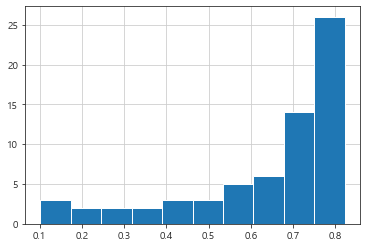

In [70]:
silhouette_df['silhouette_coeff'].hist()

In [71]:
silhouette_df.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.723394
1    0.528761
2    0.544947
Name: silhouette_coeff, dtype: float64

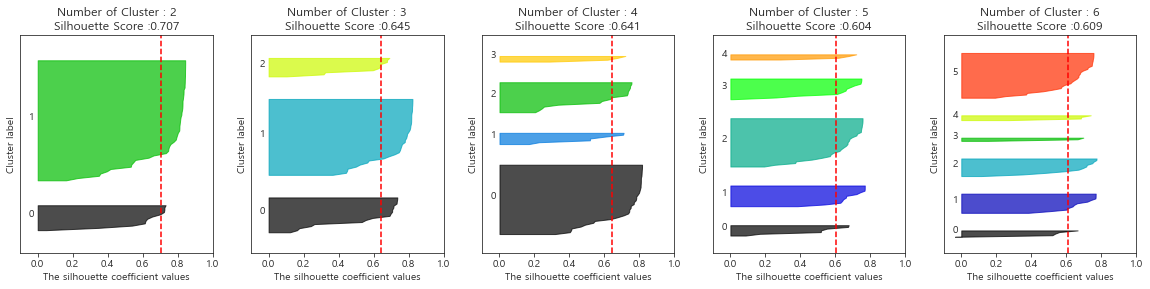

In [72]:
from sklearn.datasets import make_blobs

visualize_silhouette([2,3,4,5,6], silhouette_df.to_numpy())

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


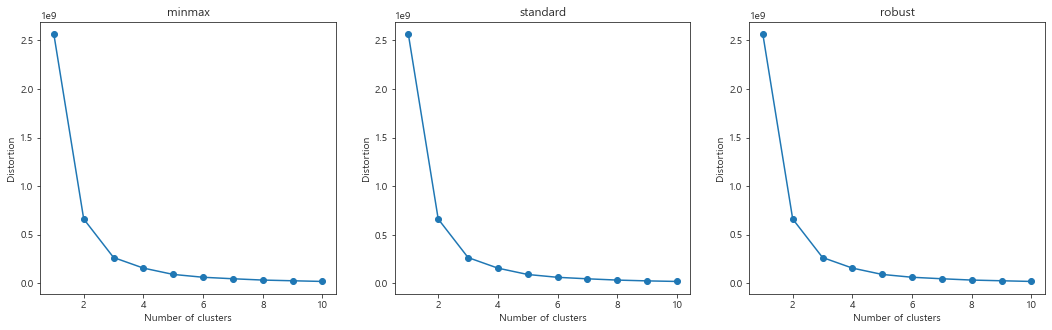

In [73]:
elbow_method(traffic_df)

In [74]:
silhouette_df_copy = silhouette_df[['accident_count','3~12종','cluster','distance']]

In [75]:
#차원 축소

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(silhouette_df_copy[['distance','accident_count','3~12종']].to_numpy())

silhouette_df_copy['pca_x'] = pca_transformed[:,0]
silhouette_df_copy['pca_y'] = pca_transformed[:,1]
silhouette_df_copy.head()

,accident_count,3~12종,cluster,distance,pca_x,pca_y
2,6,10762,2,7.659833,2809.557591,-5.562168
10,6,5072,0,10.611661,-2880.440018,0.400169
11,9,5725,0,9.882904,-2227.437015,2.540153
15,1,10544,2,8.452198,2591.552208,-10.033915
23,7,8623,2,10.180732,670.559002,-2.017052


C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


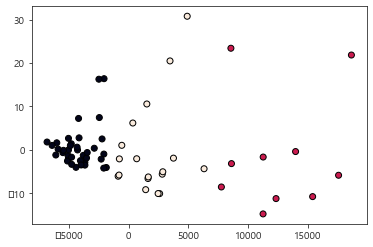

In [76]:
plt.scatter(x=silhouette_df_copy['pca_x'],y=silhouette_df_copy['pca_y'],edgecolor='k',c=silhouette_df_copy['cluster'])

In [77]:
def cluster(df, seed):
    cols = ['accident_count','3~12종','distance']
    data = df[cols].values
    data = StandardScaler().fit_transform(data)

    kmeans = KMeans(n_clusters=3, random_state=seed).fit(data)
    df['cluster_id'] = kmeans.labels_
    return df

In [78]:
group1_df = cluster(group1_df, 0)
group2_df = cluster(group2_df, 4)
group3_df = cluster(group3_df, 0)
group4_df = cluster(group4_df, 1)

In [79]:
# Clustering 2D 시각화
def cluster_plot(df):
    fig, axes = plt.subplots(1,3,figsize = (18, 6))
    sns.set_style('ticks')

    sns.scatterplot('3~12종', 'accident_count',
            data=df,
              palette = ['#ef476f', '#06d6a0', '#ffd166'],  # 118ab2
            hue="cluster_id",
            legend=False,
            s=100,
            ax = axes[0]    
    )

    sns.scatterplot('3~12종', 'distance',
            data=df,
              palette = ['#ef476f', '#06d6a0', '#ffd166'], 
            hue="cluster_id",
            legend=False,
            s=100,
            ax = axes[1]
    )

    sns.scatterplot('distance', 'accident_count',
            data=df,
              palette = ['#ef476f', '#06d6a0', '#ffd166'], 
            hue="cluster_id",
            legend=False,
            s=100,
            ax = axes[2]
    )

    plt.show()

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


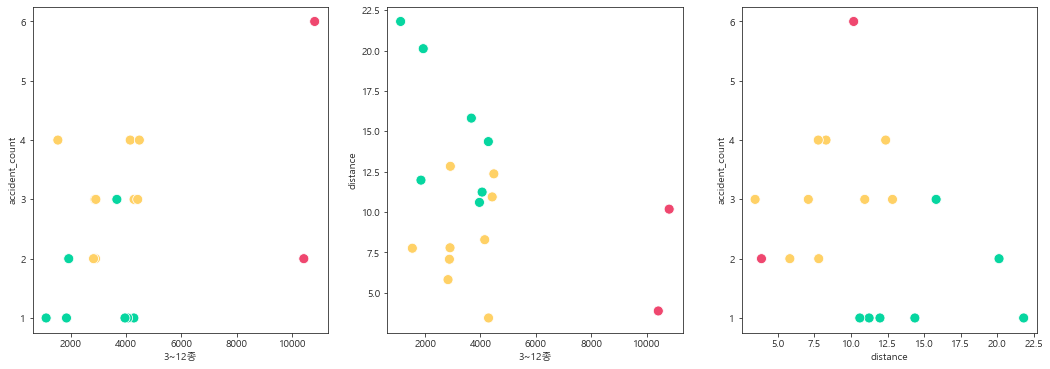

In [80]:
cluster_plot(group1_df)

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


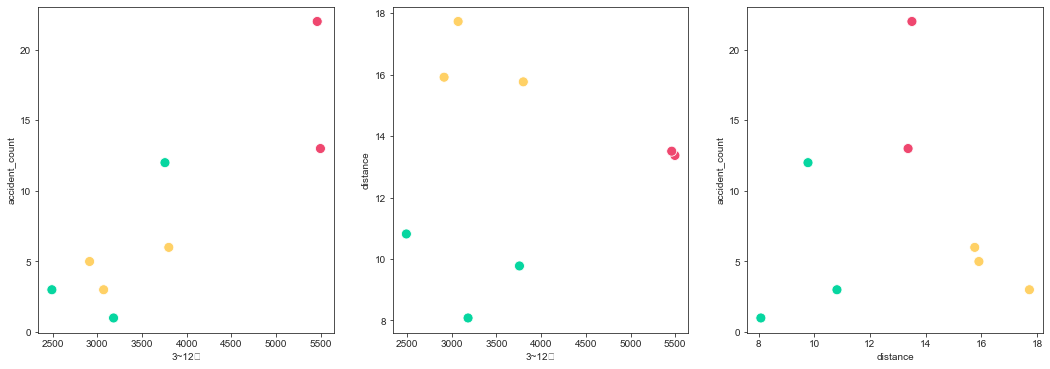

In [81]:
cluster_plot(group2_df)

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


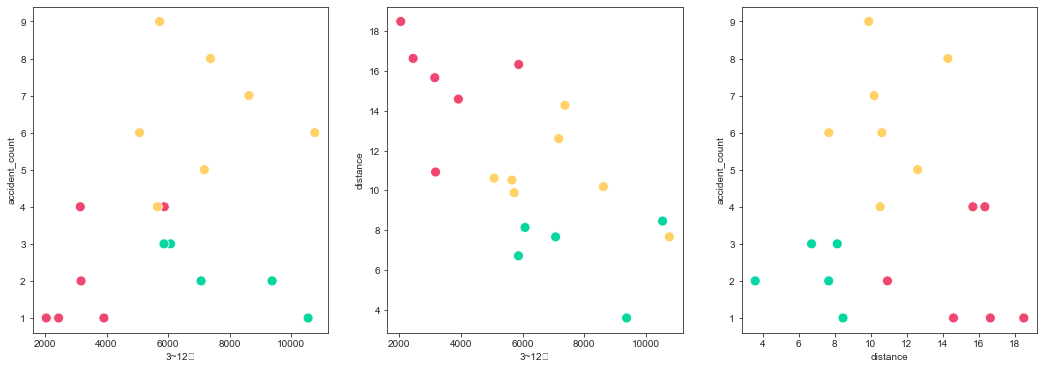

In [82]:
cluster_plot(group3_df)

C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Jo\anaconda3\envs\pydatavenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


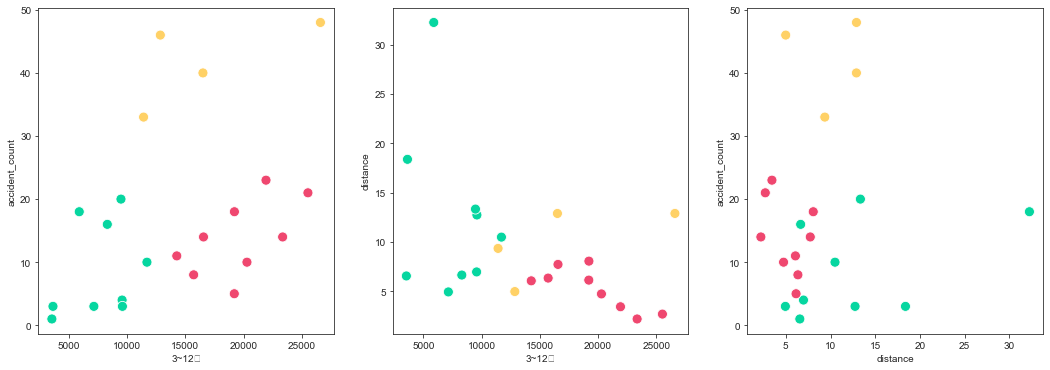

In [83]:
cluster_plot(group4_df)

In [84]:
group_concat = pd.concat([group1_df, group2_df, group3_df,group4_df]).reset_index(drop=True)

In [85]:
def cluster_color(id):
    if id == 0:
        color = '#ef476f'
        opacity = 1
    elif id == 1:
        color = '#06d6a0'
        opacity = 0.1
    else:
        color = '#118ab2'
        opacity = 0.1
        
    return color, opacity

In [100]:
counts=[]
cluster_map = folium.Map(location=[36, 127.5], tiles='cartodbpositron', zoom_start=7)
res = []
for i in range(len(group_concat)):
    startpoint = group_concat['startpoint_coor'][i]
    endpoint = group_concat['endpoint_coor'][i]

    rad = cal_rad(startpoint, endpoint)
    deg = np.rad2deg(rad)
    dist = 2.5
    origin_start = geopy.Point(startpoint)
    origin_end = geopy.Point(endpoint)

    degree = [90+deg, 270+deg]

    poly_a = []
    poly_b = []


    for de in degree:

        destination_start = geodesic(kilometers=dist).destination(origin_start, de)
        destination_end = geodesic(kilometers=dist).destination(origin_end, de)
        new_lat1, new_lon1 = destination_start.latitude, destination_start.longitude
        new_lat2, new_lon2 = destination_end.latitude, destination_end.longitude

        poly_a.append([new_lat1, new_lon1])
        poly_b.append([new_lat2, new_lon2])

        
      
    polygon_vect = np.array([poly_a[0],poly_b[0],poly_b[1],poly_a[1]])
    polygon = Polygon(polygon_vect)

    count =0
    for j in range(len(rest_df)):
      
        point = Point(rest_df['위도'][j], rest_df['경도'][j])

        if polygon.contains(point):
            count+=1

    counts.append(count)
    

    lats_vect = np.array([poly_a[0], poly_b[0]])
    lons_vect = np.array([poly_a[1], poly_b[1]])

    
    folium.Polygon(locations=[poly_a[0], poly_b[0], poly_b[1], poly_a[1]],
                  weight = 1,
                  color = None, # traffic_color(traffic_df['traffic'][i])[0], #'#4287f5',
                  fill_color = cluster_color(id = group_concat['cluster_id'][i])[0], # '#50aa50', 
                  fill_opacity=cluster_color(id = group_concat['cluster_id'][i])[1],
                  tooltip=group_concat['구간'][i]
                      ).add_to(cluster_map)
    
    if cluster_color(id = group_concat['cluster_id'][i])[0] == '#ef476f':
        res.append(group_concat.iloc[i]['구간'])    

In [101]:
import pandas as pd

rest_df = pd.read_csv('고속도로 휴게소 데이터.csv')
rest_df.head()

,No,brand,convenience,direction,maintenanceYn,routeCode,routeName,serviceAreaCode,serviceAreaCode2,serviceAreaName,svarAddr,telNo,truckSaYn,경도,위도,상태
0,1,탐앤탐스 외 5,수유실|수면실||||,부산,X,10,경부선,A00001,1,서울만남(부산)휴게소,서울 서초구 원지동 10-16,02-578-3372,X,127.042145,37.460075,정좌표
1,2,탐앤탐스 외 3,NaN,부산,X,10,경부선,A00003,5,기흥(부산)휴게소,경기 용인시 기흥구 공세로 173 기흥휴게소,031-286-5001,X,127.104246,37.235329,정좌표
2,3,드롭탑 외 5,수유실|샤워실|세탁실|수면실||,부산,X,10,경부선,A00005,9,안성(부산)휴게소,경기 안성시 원곡면 경부고속도로 365,031-655-0531,X,127.144716,37.013582,정좌표
3,4,탐앤탐스 외 2,수유실|내고장특산물||||,부산,O,10,경부선,A00030,13,망향(부산)휴게소,충남 천안시 성거읍 요방리 121,041-557-4000,X,127.180809,36.855314,정좌표
4,5,할리스 외 2,수유실|수면실|샤워실|수면실||,부산,O,10,경부선,A00032,21,옥산(부산)휴게소,충북 청원군 옥산면 오산리 589-15,043-260-1053,O,127.369664,36.658024,정좌표


In [102]:
truck_yes = rest_df[rest_df['truckSaYn'] == 'O']
truck_yes.head()

,No,brand,convenience,direction,maintenanceYn,routeCode,routeName,serviceAreaCode,serviceAreaCode2,serviceAreaName,svarAddr,telNo,truckSaYn,경도,위도,상태
4,5,할리스 외 2,수유실|수면실|샤워실|수면실||,부산,O,10,경부선,A00032,21,옥산(부산)휴게소,충북 청원군 옥산면 오산리 589-15,043-260-1053,O,127.369664,36.658024,정좌표
9,10,할리스 외 2,수유실|수면실|샤워실|세탁실||,부산,O,10,경부선,A00068,40,추풍령(부산)휴게소,경북 김천시 봉산면 광천리 691,054-430-2000,O,128.000503,36.200407,정좌표
10,11,엔제리너스,수유실|수면실|샤워실|세탁실|수면실|,부산,X,10,경부선,A00071,50,평사(부산)휴게소,경북 경산시 진량읍 경부고속도로 105,053-852-8651,O,128.868887,35.886104,정좌표
11,12,탐앤탐스 외 1,NaN,부산,X,10,경부선,A00072,44,칠곡(부산)휴게소,경북 칠곡군 왜관읍 아곡리 302,054-975-2277,O,128.428065,36.020133,정좌표
14,15,할리스 외 3,NaN,부산,O,10,경부선,A00103,30,옥천(부산)휴게소,충북 옥천군 옥천읍 매화리 251-4,043-731-8521,O,127.595173,36.296768,정좌표


In [103]:
for name, lat, lng in zip(truck_yes.serviceAreaName, truck_yes.위도, truck_yes.경도):
    folium.CircleMarker([lat, lng],
                        radius=6,         # 원의 반지름
                        color='brown',         # 원의 둘레 색상
                        weight=0.1,
                        fill=True,
                        fill_color='blue',    # 원을 채우는 색
                        fill_opacity=0.5, # 투명도    
                        popup=name
    ).add_to(cluster_map)

In [104]:
cluster_map

In [105]:
cluster_map.save('휴게소 입지 선정 결과.html')

In [ ]:
final_group1_road = group1_df[group1_df['cluster_id'] == 0].reset_index(drop=True)
final_group2_road = group2_df[group2_df['cluster_id'] == 0].reset_index(drop=True)
final_group3_road = group3_df[group3_df['cluster_id'] == 0].reset_index(drop=True)
final_group4_road = group4_df[group4_df['cluster_id'] == 0].reset_index(drop=True)

final_concat = pd.concat([final_group1_road, final_group2_road, final_group3_road, final_group4_road]).reset_index(drop=True)

In [48]:
len(res)

19